# Import Related Package

In [1]:
# Config GPU Resource
# https://stackoverflow.com/questions/55788883/limiting-gpu-memory-usage-by-keras-tf-2019
# https://www.bookstack.cn/read/TensorFlow2.0/spilt.6.3b87bc87b85cbe5d.md

GPU_NUMBER = "1"

import os
os.environ['CUDA_VISIBLE_DEVICES']=f"{GPU_NUMBER}"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(devices=gpus, device_type='GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# packages
from tensorflow import keras
import tensorflow.keras.layers 
import tensorflow.keras.backend
from tensorflow.keras import utils as np_utils
from tensorflow.python.client import device_lib
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from focal_loss import *


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import struct
import pathlib
import os
import glob
import itertools
import seaborn as sns

# Global Enviroment Variable

In [2]:
MODEl_NUMER = 1
MODEL_NAME = "cnn"
CACHE_DIR_NAME = "cae_12_pkt_44_feature"
NUMBER_OF_PKTS_PER_SESSION = 12
NUMBER_OF_FEATURES = 44
MALWARE_TYPE = {"backdoor": 0, "ddos": 1, "dos": 2, "injection": 3, \
                    "mitm": 4, "normal": 5, "password": 6, \
                    "ransomware": 7, "scanning": 8, "xss": 9}
CACHE_FILE_NAME = ["x_train.csv", "x_test.csv", "y_train.csv", "y_test.csv"]

SAVE_DIRECTORY = f"model/{MODEL_NAME}/{MODEl_NUMER}"
CACHE_DIR = f"cache/{CACHE_DIR_NAME}"


pathlib.Path(SAVE_DIRECTORY).mkdir(parents=True, exist_ok=True)

# Read Cache File

In [3]:
print("---- read csv ----")
xTrainRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[0]}").to_numpy()    
xTestRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[1]}").to_numpy()    
yTrainRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[2]}").to_numpy()    
yTestRawData = pd.read_csv(f"{CACHE_DIR}/{CACHE_FILE_NAME[3]}").to_numpy()    

xTrainRawData = xTrainRawData.reshape((-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES))
xTestRawData = xTestRawData.reshape((-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES))

print(xTrainRawData.shape)
print(xTestRawData.shape)
print(yTrainRawData.shape)
print(yTestRawData.shape)
print("---- read end ----")

print("---- normalized data ----")
yTrain = np_utils.to_categorical(yTrainRawData, len(MALWARE_TYPE))
yTest = np_utils.to_categorical(yTestRawData, len(MALWARE_TYPE))
# normalized
xTrainRawData = np.reshape(xTrainRawData, [-1, NUMBER_OF_FEATURES])
xTestRawData = np.reshape(xTestRawData, [-1, NUMBER_OF_FEATURES])
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrainRawData)
xTest = scaler.transform(xTestRawData)
xTrain = np.reshape(xTrain, [-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES])
xTest = np.reshape(xTest, [-1, NUMBER_OF_PKTS_PER_SESSION, NUMBER_OF_FEATURES])
print("---- normalized end ----")

---- read csv ----
(70000, 12, 44)
(24845, 12, 44)
(70000, 1)
(24845, 1)
---- read end ----
---- normalized data ----
---- normalized end ----


# 1DCNN

In [4]:
# Hypter parameter
LOSS = keras.losses.categorical_crossentropy
OPTIMIZER = keras.optimizers.Adam()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 44)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            8512      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 32)             6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 16)               

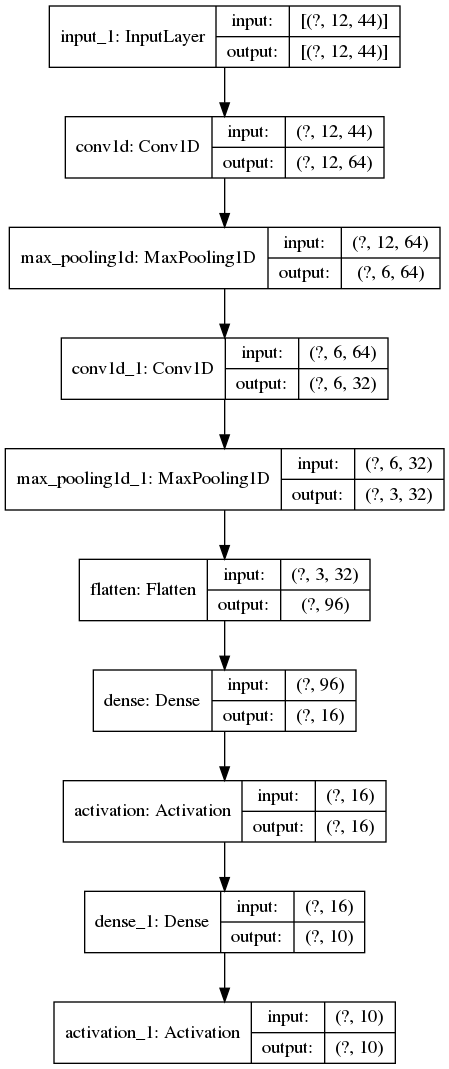

In [5]:
cnn1DInput = keras.Input(shape=(xTrain.shape[1], xTrain.shape[2]))
cnn1DLayer = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cnn1DInput)
cnn1DLayer = MaxPooling1D(2)(cnn1DLayer)
cnn1DLayer = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn1DLayer)
cnn1DLayer = MaxPooling1D(2)(cnn1DLayer)
cnn1DLayer = Flatten()(cnn1DLayer)
cnn1DLayer = Dense(units=16)(cnn1DLayer)
cnn1DLayer = Activation("relu")(cnn1DLayer)
# cnn1DLayer = Dropout(0.1)(cnn1DLayer)
cnn1DLayer = Dense(units=10)(cnn1DLayer)
cnnOutput = Activation("softmax")(cnn1DLayer)

cnn1d = keras.Model(cnn1DInput, cnnOutput)    
cnn1d.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
cnn1d.summary()

np_utils.plot_model(cnn1d,to_file=f"{SAVE_DIRECTORY}/{MODEL_NAME}.png",show_shapes=True)

# Training Stage

In [6]:
# Hyper Parameter
EPOCHS_SIZE = 30
BATCH_SIZE = 64
TRAINING_HISTORY_FILE_NAME = "training_log.csv"

In [7]:
historyLogger = tf.keras.callbacks.CSVLogger(f"{SAVE_DIRECTORY}/{TRAINING_HISTORY_FILE_NAME}", separator=",")

history = cnn1d.fit(xTrain, yTrain, #class_weight=d_class_weights,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS_SIZE,
                      callbacks=[historyLogger],
                      verbose=1)
cnn1d.save(f"{SAVE_DIRECTORY}/{MODEL_NAME}.h5")

Epoch 1/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.3681 - accuracy: 0.8984
Epoch 2/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.1803 - accuracy: 0.9505
Epoch 3/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.1492 - accuracy: 0.9580
Epoch 4/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.1298 - accuracy: 0.9632
Epoch 5/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.1163 - accuracy: 0.9672
Epoch 6/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.1099 - accuracy: 0.9677
Epoch 7/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.1024 - accuracy: 0.9695
Epoch 8/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0975 - accuracy: 0.9714
Epoch 9/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0925 - accuracy: 0.9726
Epoch 10/30
1094/1094 [==============================] - 6s 5ms/step - loss: 0.089

# Estimate Performance

In [8]:
#Hypter parameter
LABELS = ["backdoor", "ddos", "dos", "injection",
                    "mitm", "normal", "password",
                    "ransomware", "scanning", "xss"]
ESTIMATED_ROOT_DIR = f"{SAVE_DIRECTORY}"
TRAINING_HISTORY_FILE_NAME = "training_log.csv"

In [9]:
# Function
# https://zhuanlan.zhihu.com/p/40156908
def get_FLOPs(modelPath):
    tf.compat.v1.reset_default_graph()
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(modelPath)

            runMeta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=runMeta, cmd='op', options=opts)   
            return flops.total_float_ops

def plot_training_history(csvPath, savedDirPath):
    history = pd.read_csv(csvPath, sep=',', engine='python')
    plt.plot(history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.savefig(f"{savedDirPath}/train_acc.png")
    plt.show()
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig(f"{savedDirPath}/train_loss.png")
    plt.show()



def cm_analysis(yTrue, yPred, fileName, labels, ymap=None, figSize=(10,10)):
    """
    reference: https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
    
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      yTrue:    true label of the data, with shape (nsamples,)
      yPred:    prediction of the data, with shape (nsamples,)
      fileName:  fileName of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original yTrue, yPred and labels must align.
      figSize:   the size of the figure plotted.
    """
    if ymap is not None:
        yPred = [ymap[yi] for yi in yPred]
        yTrue = [ymap[yi] for yi in yTrue]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(yTrue, yPred)#, labels=labels)
    cmSum = np.sum(cm, axis=1, keepdims=True)
    cmPerc = cm / cmSum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cmPerc[i, j]
            if i == j:
                s = cmSum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figSize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(fileName)

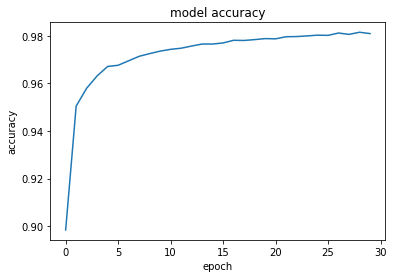

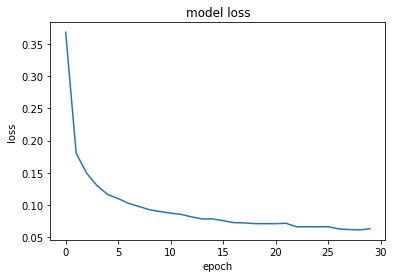

              precision    recall  f1-score   support

    backdoor       1.00      0.99      0.99      3000
        ddos       0.98      0.91      0.94      3000
         dos       1.00      1.00      1.00      3000
   injection       0.96      0.97      0.96      3000
        mitm       0.77      0.94      0.85       117
      normal       0.99      0.98      0.99      3000
    password       0.93      0.99      0.96      3000
  ransomware       0.96      0.99      0.98       728
    scanning       0.98      0.99      0.99      3000
         xss       0.97      0.97      0.97      3000

    accuracy                           0.97     24845
   macro avg       0.95      0.97      0.96     24845
weighted avg       0.97      0.97      0.97     24845



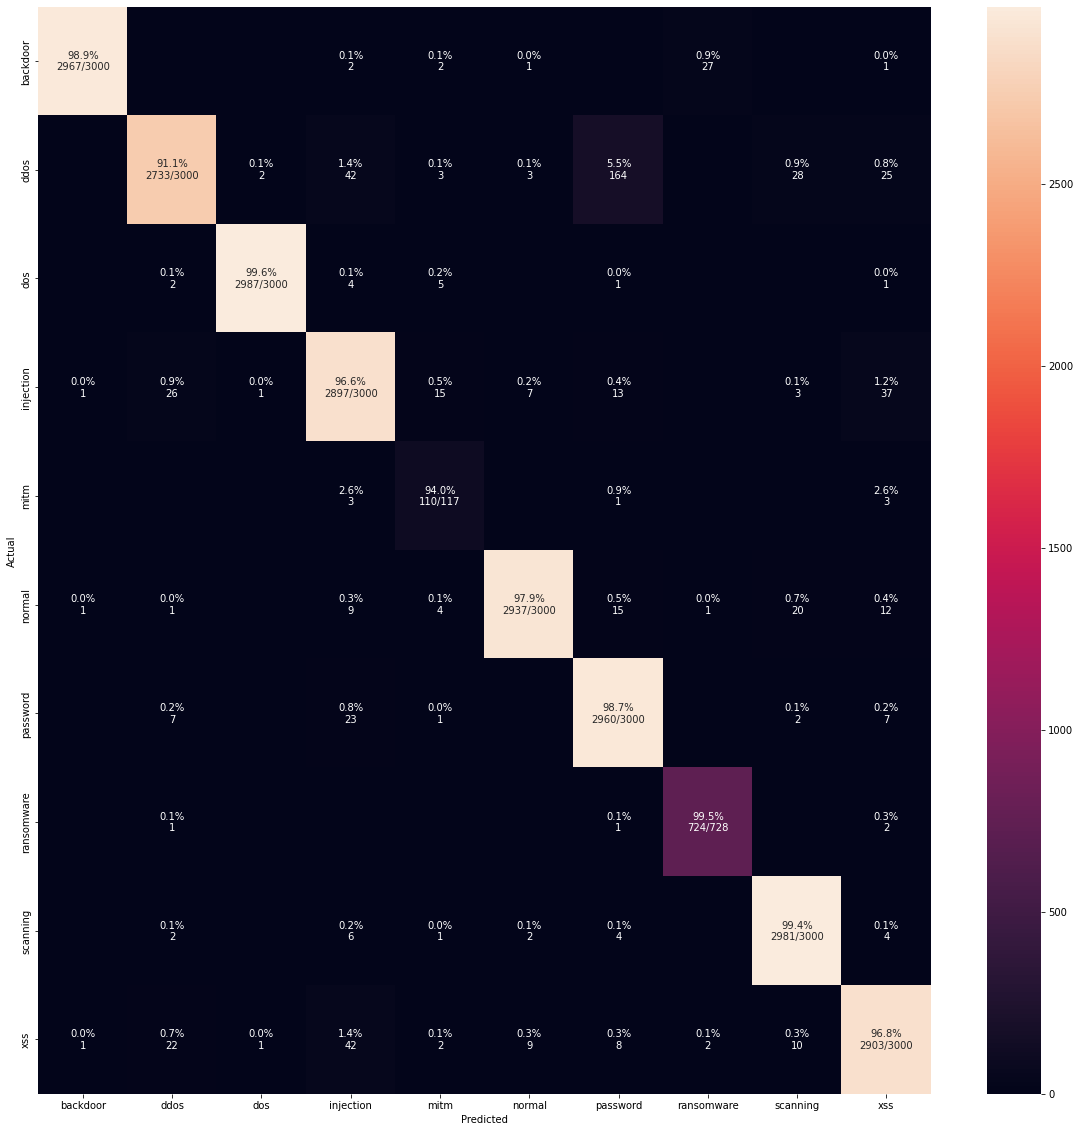

In [10]:
# print(get_FLOPs("model/cnn2d_model_2.h5"))
# print(get_FLOPs("autoencoder_1dcnn/4/1dcnn.h5"))
# plot_training_history("autoencoder_1dcnn/0/autoencoder_1dcnn_training_log.csv")
plot_training_history(f"{ESTIMATED_ROOT_DIR}/{TRAINING_HISTORY_FILE_NAME}",  ESTIMATED_ROOT_DIR)
model = tf.keras.models.load_model(f"{ESTIMATED_ROOT_DIR}/{MODEL_NAME}.h5")
predictions = model.predict(xTest)
predictions = np.argmax(predictions,axis=1)

cm_analysis(np.argmax(yTest,axis=1), predictions, f"{ESTIMATED_ROOT_DIR}/confusion.png", LABELS, ymap=None, figSize=(20,20))
# # https://github.com/howl-anderson/WeatherBot_NLU/issues/4
with open(f'{ESTIMATED_ROOT_DIR}/f1score.txt', 'w') as f:
    ans = classification_report(np.argmax(yTest,axis=1), predictions,  target_names=LABELS)
    f.write(ans)   
# https://blog.csdn.net/jmh1996/article/details/114935105
print(ans)